In [36]:
import scipy.ndimage
import pandas as pd
import re
import glob
import numpy as np

losses_dict = {}
model_file_dict = {}
lr_dict = {}
for name in glob.glob("log/*.log"):
    with open(name) as f:
        log = f.read()
    
    model_file = re.findall(r"Saving model to (.*)", log)
    shortname = name.split(".")[0].split("/")[1]
    model_file_dict[shortname] = model_file[-1] if model_file else ""
    losses_dict[shortname] = [float(v) for v in re.findall(r'mean loss (.*) \|', log) if not np.isnan(float(v))]
    lr_dict[shortname] =  [float(v) for v in re.findall(r'lr (.*) data', log)]


In [37]:
import torch

last_saves = dict()
for name in glob.glob("models_diff/*.cpkt"):
    if "prior_diff_real" in name:
        continue
    shortname, epoch_string = name.split("/")[1].split("_epoch_")
    epoch_string = epoch_string.split(".")[0]
    if epoch_string == "on_exit":
        epoch = np.inf
    else:
        epoch = int(re.findall("(\d+)", epoch_string)[0])
    if shortname in last_saves:
        if last_saves[shortname][1] < epoch:
            last_saves[shortname] = (name, epoch)
    else:
        last_saves[shortname] = (name, epoch)

for shortname, (name, _) in last_saves.items():
    _, _, config = torch.load(name)
    if "losses" in config:
        losses_dict[shortname] = config['losses']

In [38]:
last_saves

{'reproduce_reference_config_continue_06_05_2023_17_45_06': ('models_diff/reproduce_reference_config_continue_06_05_2023_17_45_06_epoch_on_exit.cpkt',
  inf),
 'tabpfn_large_lr00003_warm_start_06_06_2023_17_06_35': ('models_diff/tabpfn_large_lr00003_warm_start_06_06_2023_17_06_35_epoch_on_exit.cpkt',
  inf),
 'vanilla_lr0001_new_05_31_2023_23_16_43': ('models_diff/vanilla_lr0001_new_05_31_2023_23_16_43_epoch_290.cpkt',
  290),
 'download': ('models_diff/download_epoch_100.cpkt', 100),
 'vanilla_tabpfn_lr0001_post_refactor_try_reproduce_06_02_2023_00_02_28': ('models_diff/vanilla_tabpfn_lr0001_post_refactor_try_reproduce_06_02_2023_00_02_28_epoch_210.cpkt',
  210),
 'reproduce_reference_config_06_02_2023_17_08_59': ('models_diff/reproduce_reference_config_06_02_2023_17_08_59_epoch_on_exit.cpkt',
  inf),
 'tabpfn_large_lr0001_06_05_2023_18_57_22': ('models_diff/tabpfn_large_lr0001_06_05_2023_18_57_22_epoch_on_exit.cpkt',
  inf),
 'tabpfn_large_lr0001_06_05_2023_23_08_11': ('models_diff/t

In [39]:
# for drop in ['lr_00001', 'defaults_k_aggregate_8_batch_size_128', 'lr_001']:
#     del losses_dict[drop]

In [40]:
def make_long_loss_df(losses_dict, smooth=None):
    max_len = max(len(v) for v in losses_dict.values())
    bla = pd.DataFrame(index=range(max_len), columns=losses_dict.keys())
    for name, losses in losses_dict.items():
        if smooth is not None:
            losses = smooth(losses)
        bla[name].iloc[:len(losses)] = losses
    long = bla.unstack().reset_index()
    long.columns = ['run', 'epoch', 'loss']
    return long

In [41]:
[x for x in losses_dict if "scratch" in x]

['predict_mlp_from_scratch_lr0003_warm_start_continue',
 'predict_mlp_from_scratch_lr0003']

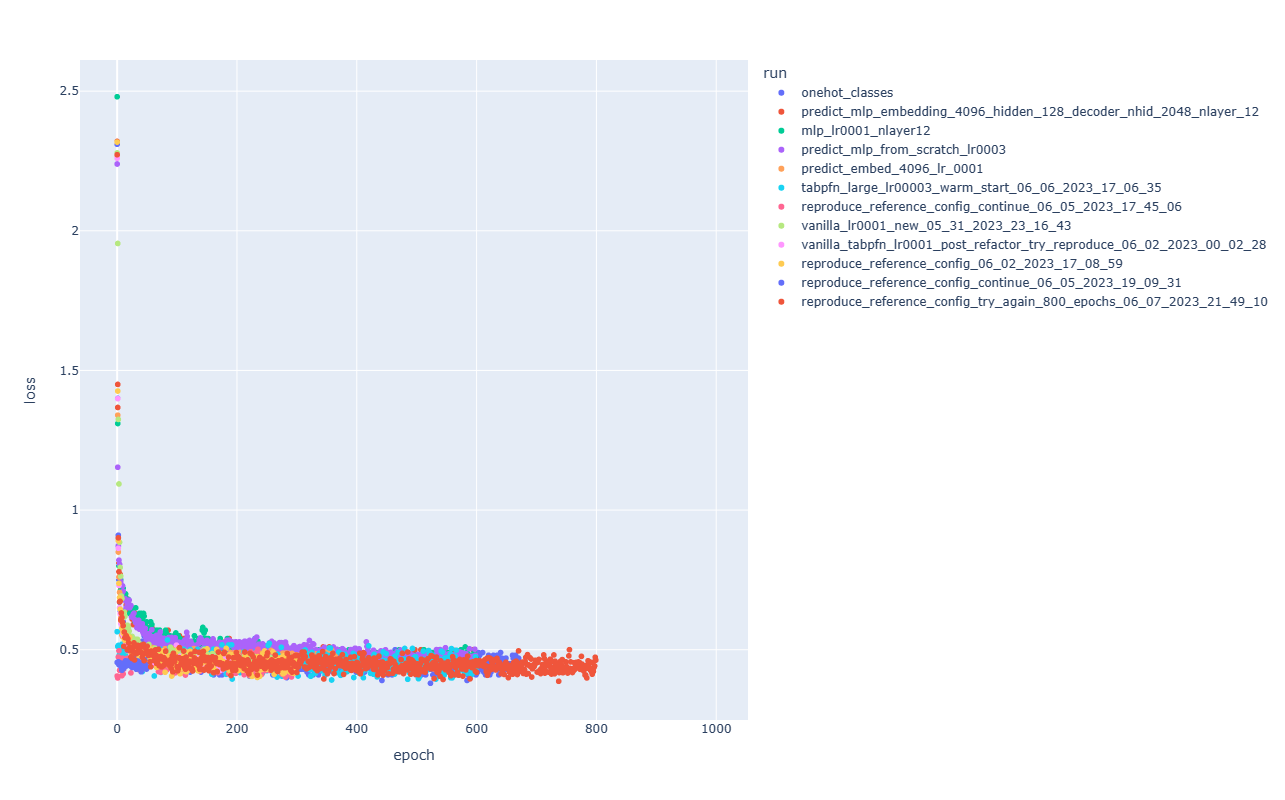

In [42]:
import plotly.express as px
show_only = ['onehot_classes', 'predict_embed_4096_lr_0001','mlp_lr0001_nlayer12', 'predict_mlp_no_token_embed_1024',
             'predict_mlp_embedding_4096_hidden_128_decoder_nhid_2048_nlayer_12', 'no_double_embedding_continued', "really_big_model_lr00001_tabpfn_vanilla_warm_start",
            'predict_mlp_embedding_4096_hidden_128_decoder_nhid_2048_nlayer_12_lr003', 'predict_mlp_from_scratch_lr0003_warm_start_continue',
            'predict_warm_start_embed_2048', 'predict_embed_4096_lr_0001_nhead_16', 'predict_mlp_two_layer_decoder_embedd_4096', 'predict_mlp_embedding_continue_3_nlayer_12_lr003',
             'really_big_model_lr0001_model_maker_warm_start', 'predict_mlp_from_scratch_lr0003', 'reproduce_reference_config_06_02_2023_17_08_59']

show_only = ['onehot_classes', 'predict_embed_4096_lr_0001','mlp_lr0001_nlayer12', 'predict_mlp_no_token_embed_1024',
             'predict_mlp_embedding_4096_hidden_128_decoder_nhid_2048_nlayer_12',            
             'predict_mlp_from_scratch_lr0003', 'reproduce_reference_config_06_02_2023_17_08_59', 'vanilla_tabpfn_lr0001_post_refactor_try_reproduce_06_02_2023_00_02_28',
            'vanilla_lr0001_new_05_31_2023_23_16_43', 'reproduce_reference_config_continue_06_05_2023_19_09_31', 'reproduce_reference_config_continue_06_05_2023_17_45_06',
            'reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10', 'tabpfn_large_lr00003_warm_start_06_06_2023_17_06_35']

long_df = make_long_loss_df(losses_dict)
long_df = long_df[long_df.run.isin(show_only)]
fig = px.scatter(long_df, x="epoch", y='loss', color="run")
fig.update_layout(height=800)
fig

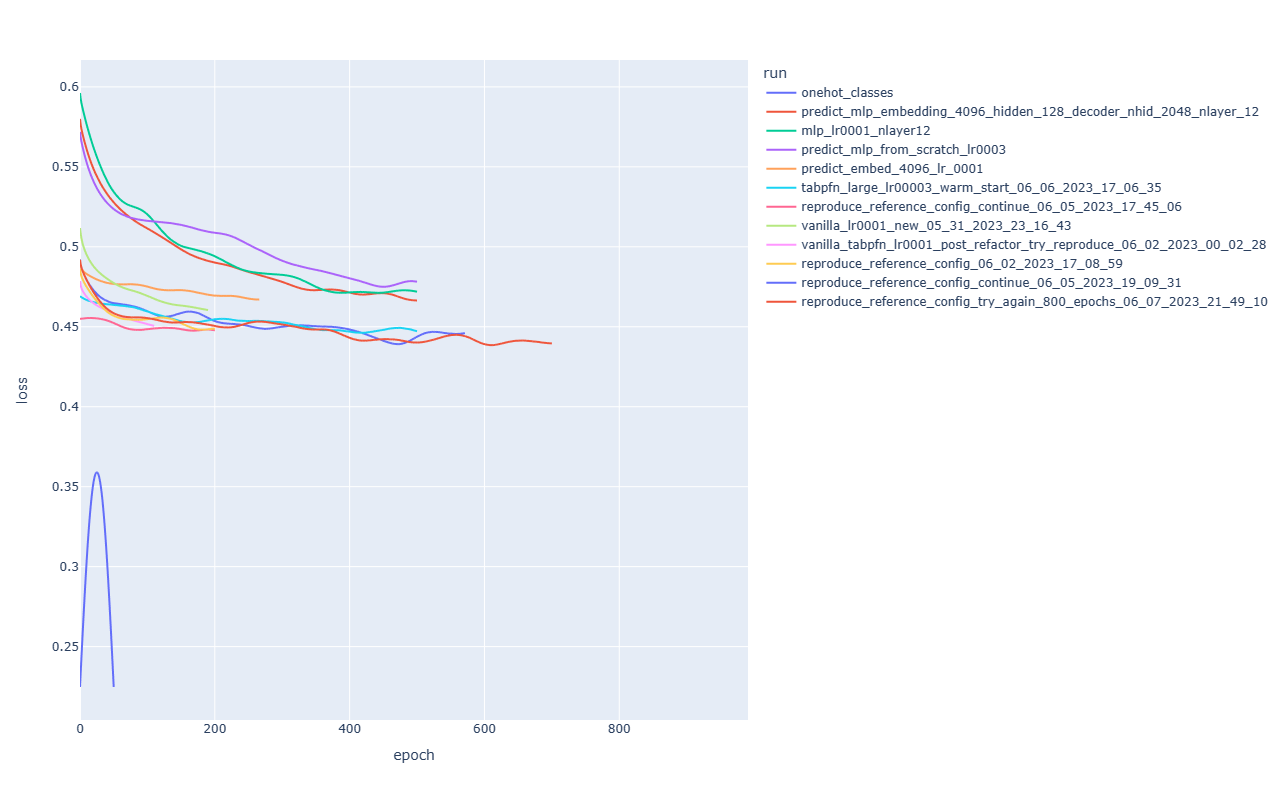

In [43]:
from scipy.signal import convolve, windows
import numpy as np
from scipy.signal import savgol_filter
# yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
#window = windows.gaussian(50, 10)
window = windows.gaussian(100, 20)
#window = windows.gaussian(20, 4)
window /= window.sum()
long_df = make_long_loss_df(losses_dict, smooth=lambda x : convolve(x, window, mode="valid") if x else [])
#long_df = make_long_loss_df(losses_dict, smooth=lambda x : savgol_filter(x[30:], 51, 3, mode='nearest') if x and len(x) > 82 else [])
long_df = long_df[long_df.run.isin(show_only)]
fig = px.line(long_df, x="epoch", y='loss', color="run")
fig.update_layout(height=800)

In [115]:
from tabpfn.transformer_make_model import load_model_maker

In [116]:
model_file_dict['predict_mlp_embedding_4096_hidden_128_decoder_nhid_2048_nlayer_12_lr003']

'models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_96.cpkt'

In [117]:
!ls models_diff/prior_diff_real_checkpoint_retraining_batch_2048_lr0001_n_0_epoch*

models_diff/prior_diff_real_checkpoint_retraining_batch_2048_lr0001_n_0_epoch_on_exit.cpkt


In [166]:
load_model_maker('models_diff/prior_diff_real_checkpoint_retraining_batch_2048_lr0001_n_0_epoch_on_exit.cpkt', model_maker=True)

RuntimeError: Error(s) in loading state_dict for TransformerModelMaker:
	Missing key(s) in state_dict: "decoder.mlp.0.weight", "decoder.mlp.0.bias", "decoder.mlp.2.weight", "decoder.mlp.2.bias". 
	Unexpected key(s) in state_dict: "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias". 

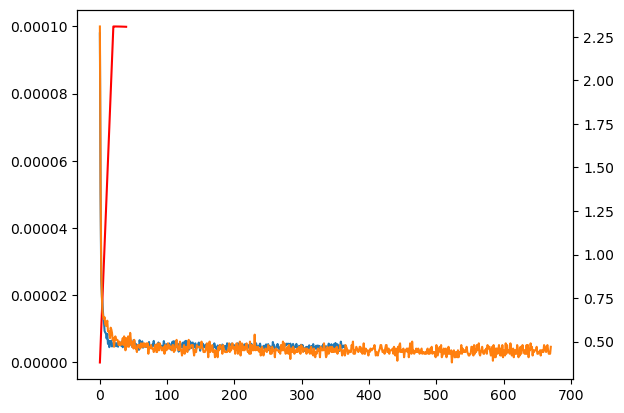

Bad pipe message: %s [b'#e\x83\xa2\x965\xe6\xa0\x0fH\x1f\x85)E.\xee\xd7\x88 \xe1\x8e\x83QY\xdf\xce\xc5\xdc\x08\xf5\xea\xdc\xaa\x87\r\xb4\xa6\x1e\x0c\x0eZ\x13\xea\xe9\n\xd8\xd6;P\x9dV\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08']
Bad pipe message: %s [b'\n\x08\x0b\x08\x04\x08\x05\x08']
Bad pipe message: %s [b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b"{FV\xfb\xaf\xd0\xa0\x853\x03#\x85A\x158\xfb\xb4[\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0", b'3\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0']
Ba

In [369]:
import matplotlib.pyplot as plt
#plt.plot(lr_dict['lr_001'], c='g')
plt.plot(lr_dict['really_big_model_lr00001_model_maker_warm_start'], c='r')
#plt.plot(lr_dict['onehot_classes'], c='b')


ax = plt.twinx()
#ax.plot(losses_dict['lr_001'])
ax.plot(losses_dict['predict_embed_4096_lr_0001'])
ax.plot(losses_dict['onehot_classes'])


In [354]:
locals()['meh'] = 1

In [355]:
meh

1